In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.optimize import minimize
from scipy.optimize import leastsq

In [2]:
from poly_func import getMatrixP

Implement the modified miniziation function to obtain coefficients of polynomial equations

In [4]:
params = ['x1', 'x2']
order = 2
nscans = 6
k1 = 0.1
k2 = 5
k11 = 0.01
k22 = 0.05
k12 = 0
norm_val = 10
xmin = 1
xmax = 2

In [5]:
def generate_linear_data(nscans, p_err=0.01):
    dx1 = np.random.uniform(xmin, xmax, nscans)
    dx2 = np.random.uniform(xmin, xmax, nscans)
    norm = np.array([norm_val]* nscans)
    
    data = norm + k1*dx1 + k2*dx2
    error = data * np.random.normal(loc=0, scale=p_err, size=nscans)
    input_matrix = np.array([dx1, dx2])
    
#     return (input_matrix, data, error)
    return (input_matrix, data+error, error)

In [6]:
def generate_quad_data(nscans, p_err=0.01):
    dx1 = np.random.uniform(xmin, xmax, nscans)
    dx2 = np.random.uniform(xmin, xmax, nscans)
    norm = np.array([norm_val]* nscans)
    
    data = norm + k1*dx1 + k2*dx2 + k11*dx1*dx1 + k22*dx2*dx2 + k12*dx1*dx2
    error = data * np.random.normal(loc=0, scale=0.1, size=nscans)
    input_matrix = np.array([dx1, dx2])
    
    return (input_matrix, data+error, error)

In [7]:
generate_data = generate_quad_data

In [3]:
def get_N_coeffienct(n_x, order):
    N = 1
    for io in range(1, order+1):
        multi = 1
        for j in range(io):
            multi *= n_x + j
        multi /= math.factorial(io)
        N+= multi
    return N

In [6]:
get_N_coeffienct(11, 3)

364.0

In [9]:
def get_N_entry(n_x, order):
    multi = 1
    for j in range(order):
        multi *= n_x + j
    multi /= math.factorial(order)

    return multi

In [10]:
def get_objective_func(P, data, error):
    """The objective function to be minized"""
    nscans = P.shape[0]
    def objective(X):
        return sum( (np.matmul(P, X) - data)**2/error**2 )/nscans
    
    return objective

In [11]:
def get_objective_func_noError(P, data, error):
    """The objective function to be minized"""
    nscans = P.shape[0]
    def objective(X):
        return sum( (np.matmul(P, X) - data)**2 )/nscans
    
    return objective

In [11]:
nscans = 6
in_matrix, data, error = generate_data(nscans, 0.05)
test_matrix, test_data, test_error = generate_data(nscans, 0.05)

In [12]:
P = getMatrixP(in_matrix, order)

In [13]:
P.shape

(6, 6)

In [14]:
objective = get_objective_func(P, data, error)
objective_no_error = get_objective_func_noError(P, data, error)
obj_test = get_objective_func_noError(P, test_data, error)

In [15]:
X0 = [1]*int(get_N_coeffienct(len(params), order))

In [16]:
objective(X0)

273.7699261013762

In [17]:
res = minimize(
    objective, X0, method='nelder-mead', 
    options={'xtol':1e-8, 'disp':True}
)
print(res.success)

False


In [18]:
print(objective(res.x))
print(res.message)

0.325290698247
Maximum number of function evaluations has been exceeded.


In [19]:
res_no_error = minimize(
    objective_no_error, X0, method='nelder-mead', 
    options={'xtol':1e-8, 'disp':True}
)
print(res_no_error.success)

False


In [20]:
print("Truth: " + " ".join("{:.2f}".format(xx) for xx in [norm_val, k1, k2, k11, k22, k12]))
X = res.x.tolist()
X2 = res_no_error.x.tolist()
XP = np.matmul(np.linalg.pinv(P), data)
print("With error: " + " ".join(["{:.2f}".format(xx) for xx in X]))
print("No error: " + " ".join(["{:.2f}".format(xx) for xx in X2]))
print("Psudo-Inv: " + " ".join(["{:.2f}".format(xx) for xx in XP]))
print(objective_no_error(X))
print(objective_no_error(X2))
print(objective_no_error(XP))
print(obj_test(X))
print(obj_test(X2))
print(obj_test(XP))

Truth: 10.00 0.10 5.00 0.01 0.05 0.00
With error: -6.56 6.81 25.64 -0.64 -5.16 -5.24
No error: 78.61 -27.66 -71.02 -13.32 52.07 -0.32
Psudo-Inv: 314.60 -220.48 -208.06 180.88 -241.04 199.14
3.91750625669
0.677770942441
6.03073643896e-26
7.31078147073
13.3879581429
13.3687873959


In [12]:
def study_scans(nscans, p_err=0.01):
    in_matrix, data, error = generate_data(nscans, p_err)
    test_data = generate_data(nscans, p_err)[1]

    P = getMatrixP(in_matrix, order)
    objective = get_objective_func(P, data, error)
    objective_no_error = get_objective_func_noError(P, data, error)
    obj_test = get_objective_func_noError(P, test_data, error)
    
    X0 = [1]*int(get_N_coeffienct(len(params), order))
    res = minimize(
        objective, X0, method='nelder-mead', 
        options={'xtol':1e-8, 'disp':False}
    )

    res_no_error = minimize(
        objective_no_error, X0, method='nelder-mead', 
        options={'xtol':1e-8, 'disp':False}
    )
    
    X = res.x.tolist()
    X2 = res_no_error.x.tolist()    
    XP = np.matmul(np.linalg.pinv(P), data)

    return obj_test(X), obj_test(X2), obj_test(XP)

In [14]:
def plot(res_list, label_list, out_name):
    res1 = res_list[0]
    mean = np.mean(res1)
    std = np.std(res1)
    hist_x_max = mean + 3*std
    hist_x_min = mean - 3*std
    nbins = 50
    for res, label in zip(res_list, label_list):
        plt.hist(res, bins=nbins, range=(hist_x_min, hist_x_max),
                 histtype='step', label=label, lw=2)

    plt.legend()
    plt.savefig(out_name)

In [15]:
def stats(results):
    for ir in results:
        print(np.mean(ir), np.std(ir))

In [16]:
labels = ['with error', 'no error', 'pseudo-inverse']

7.8240679589 2.00197157638
8.2842775873 2.27609261783
8.30862536463 2.27407642629


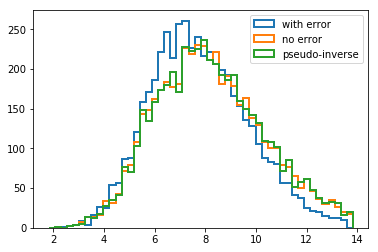

In [37]:
res_with_error100 = []
res_no_error100 = []
res_pinv_error100 = []
for i in range(5000):
    with_error, no_err, pinv_err = study_scans(30, 0.05)
    res_with_error100.append(with_error)
    res_no_error100.append(no_err)
    res_pinv_error100.append(pinv_err)

res100 = [res_with_error100, res_no_error100, res_pinv_error100]

plot(res100, labels)
stats(res100)

7.74020186161 1.98961269991
8.21018300449 2.23920081819
8.24283820662 2.2465332442


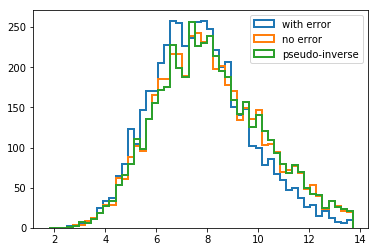

In [17]:
res_with_error100 = []
res_no_error100 = []
res_pinv_error100 = []
for i in range(5000):
    with_error, no_err, pinv_err = study_scans(30, 0.05)
    res_with_error100.append(with_error)
    res_no_error100.append(no_err)
    res_pinv_error100.append(pinv_err)

res100 = [res_with_error100, res_no_error100, res_pinv_error100]

plot(res100, labels, 'test_5pecent_error.pdf')
stats(res100)

7.80639121299 2.01986000544
8.26476382569 2.25140288359
8.28823036049 2.24922657473


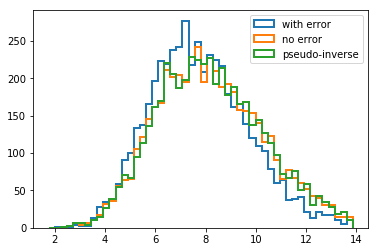

In [19]:
results = []
results.append([])
results.append([])
results.append([])

for i in range(5000):
    with_error, no_err, pinv_err = study_scans(30, 0.10)
    results[0].append(with_error)
    results[1].append(no_err)
    results[2].append(pinv_err)

plot(results, labels)
stats(results)

In [4]:
70*1000000/25000

2800.0

In [5]:
2800/32

87.5